In [1]:
from fish_helpers import *
import time
from functools import partial
from multiprocessing import Pool
import pylab as pl
from IPython import display
import tqdm.notebook as tqdm
import math
import random
import operator
import sys
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib._color_data as mcd
from sklearn.metrics.pairwise import euclidean_distances
base_path = '/bigstore/GeneralStorage/Zach/CSI/Hippocampus/'
if not os.path.exists(base_path):
    os.mkdir(base_path)

Preprocess matrix
-SCVI
-Prefilter genes (Low variation/explained varience)
Classifier
-defined: cost(KNN avg % Accurate)
-dendogram: cost(Weighted 1NN)
Imputation
-cost(KNN avg avg distance in Z)


In [4]:
SCMatrix = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.relavent_normalized_df.csv')
SCMatrix = SCMatrix.astype('float32')
SCMatrix.head()

ModuleNotFoundError: No module named 'pandas.core.internals.managers'; 'pandas.core.internals' is not a package

In [ ]:
#Filtering Genes Needs to be less than 1 Gb final size
# Lowly expressed
# Low Varience Genes


In [3]:
from scipy.sparse import csr_matrix
SCMatrix_Sparse = csr_matrix(SCMatrix)

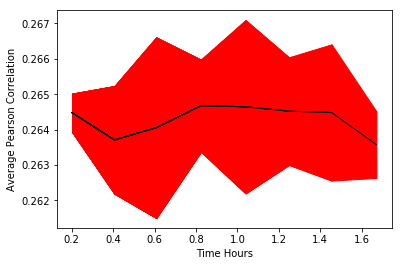

Iteration 8


In [ ]:
class CompressedSensingClass(object):
    def __init__(self,matrix,
                 genes='',
                 cells='',
                 npos=50,
                 nbits=18,
                 ncpu=1,
                 pop_ncpu=1,
                 keepers=10,
                 mutation_rate=0.1,
                 offspring_number=0,
                 mutation_number=0,
                 k=100,
                 sample=1000,
                 survivors=[],
                 iterations=100,
                 base_path='',
                 color='r',
                 fresh=True,
                 verbose=True):
        self.fresh = fresh
        self.verbose = verbose
        if base_path == '':
            base_path = os.path.join(os.getcwd(),'Results')
        self.base_path = base_path
        if not os.path.exists(self.base_path):
            os.mkdir(self.base_path)
        else:
            print('Found Existing Path\n',self.base_path)
            if self.fresh:
                print('base_path already exists and will be overwritten')
                shutil.rmtree(self.base_path)
                os.mkdir(self.base_path)
            else:
                print('loading dict from file isnt supported yet')
#                 try:
#                     temp_dict = pickle.load(open(os.path.join(self.base_path,'class_dict.pkl'),'rb'))
#                     self.__dict__ = temp_dict
                    
#                 except:
#                     continue
        if isinstance(matrix,type(csr_matrix([0]))):
            self.matrix = matrix.copy()
        elif isinstance(matrix,type(pd.DataFrame())):
            self.matrix = csr_matrix(matrix)
        else:
            raise ValueError('Unknown Matrix imput type: ',type(matrix))
        if genes == '':
            self.genes = list(matrix.index)
        else:
            self.genes = genes
        if cells == '':
            self.cells = list(matrix.columns)
        else:
            self.cells = cells
        del matrix
        self.ngenes = len(self.genes)
        self.ncells = len(self.cells)
        self.npos = npos
        self.nbits =nbits
        self.ncpu = ncpu
        self.pop_ncpu = pop_ncpu
        self.keepers = keepers
        self.ideal = np.zeros(self.ngenes)
        self.ideal[0:npos] = 1
        self.ideal = list(self.ideal)
        self.mutation_rate = mutation_rate
        self.offspring_number = offspring_number
        self.mutation_number = mutation_number
        self.k = k
        self.sample = sample
        self.survivors = survivors
        self.iterations = iterations
        self.color = color
#         pickle.dump(self.matrix,open(os.path.join(self.base_path,'matrix.pkl'),'wb'))

    def generate_random(self):
        species = np.zeros((self.ngenes,self.nbits))
        for i in range(self.nbits):
            x =random.sample(list(range(self.ngenes)),self.npos)
            species[x,i] = 1
        return species

    def generate_starting_survivors(self):
        survivors = []
        for k in range(self.keepers):
            survivors.append(self.generate_random())
        self.survivors = survivors

    def generate_mutations(self,species):
        mutated = species.copy()
        for y in range(self.nbits):
            for x in random.sample(list(range(self.ngenes)),int(self.mutation_rate*self.ngenes)):
                mutated[x,y] = random.sample(self.ideal,1)[0]
        return mutated

    def generate_offspring(self,species,mate):
        offspring = species.copy()
        for y in range(self.nbits):
            for x in random.sample(list(range(self.ngenes)),int(self.ngenes/2)):
                offspring[x,y] = mate[x,y]
        return offspring

    def generate_progenerators(self):
        progenerators = self.survivors.copy()
        for species in self.survivors:
            for i in range(self.offspring_number):
                mate = self.survivors[random.randint(0,self.keepers-1)].copy()
                progenerators.append(self.generate_offspring(species,mate))
        self.progenerators = progenerators

    def pfunc_generate_mutations(self,species):
        ppopulation = []
        for i in range(self.mutation_number):
            ppopulation.append(self.generate_mutations(species))
        return ppopulation

    def generate_population(self):
        population = self.progenerators.copy()
        if self.mutation_number>0:
            if self.pop_ncpu==1:
                for species in self.progenerators:
                    for i in range(self.mutation_number):
                        population.append(self.generate_mutations(species))
            else:
                sys.stdout.flush()
                with Pool(self.pop_ncpu) as p:
                    for ppopulation in p.imap(self.pfunc_generate_mutations,self.progenerators,chunksize=1):
                        for species in ppopulation:
                            population.append(species)
                sys.stdout.flush()
        self.population = population

    def generate_readout(self,species):
        readout = np.empty((self.ncells,self.nbits))
        out = []
        for i in range(self.nbits):
            readout[:,i] = self.matrix.multiply(species[:,i][...,None]).sum(axis=0)
        return readout

    def calculate_metric(self,readout):
        X = readout.copy()
        matrix_df = pd.DataFrame(self.matrix.A,index=self.genes,columns=self.cells)
        cells = np.array(self.cells)
        n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
        dist = euclidean_distances(X, X[n,:])
        rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
        metrics = []
        correlations = []
        for i,idx in enumerate(n):
            cell = cells[idx]
            knn = cells[rank[:,i]]
            knn = knn[knn!=cell]
            sig = matrix_df[cell]
            avg = np.average(matrix_df[knn[1:]],axis=1)
            metric = np.divide(np.sqrt(np.sum(np.square(np.subtract(sig,avg)))),self.nbits)
            correlation = spearmanr(sig,avg)[0]
            metrics.append(metric)
            correlations.append(correlation)
        metric = np.average(metrics)
        correlation = np.average(correlations)
        del matrix_df
        return metric,correlation

    def pfunc(self,species):
        readout = self.generate_readout(species)
        metric,correlation = self.calculate_metric(readout)
        return species,readout,metric,correlation
    
    def selection(self):
        new_population = []
        readouts = []
        metrics = []
        correlations = []
        if self.ncpu==1:
            for species in tqdm.tqdm(self.population):
                species,readout,metric,correlation = self.pfunc(species)
                new_population.append(species)
                readouts.append(readout)
                metrics.append(metric)
                correlations.append(correlation)
        else:
            sys.stdout.flush()
            with Pool(self.ncpu) as p:
                for species,readout,metric,correlation in tqdm.tqdm(p.imap(self.pfunc,self.population,chunksize=1),total=len(self.population)):
                    new_population.append(species)
                    readouts.append(readout)
                    metrics.append(metric)
                    correlations.append(correlation)
            sys.stdout.flush()
        df = pd.DataFrame(index=range(len(self.population)))
        df['population'] = new_population
        df['metrics'] = metrics
        df['readouts'] = readouts
        df['correlations'] = correlations
        df = df.sort_values('correlations',ascending=False)
        survivors = df.iloc[:self.keepers]
        self.metrics = list(survivors['metrics'])
        self.readouts = list(survivors['readouts'])
        self.correlations = list(survivors['correlations'])
        self.survivors = list(survivors['population'])
        self.elite_survivor = self.survivors[0]
    
    def populate(self):
        self.generate_progenerators()
        self.generate_population()
            
    def evolve(self):
        start_time = time.time()
        self.X = []
        self.Y = []
        self.max = []
        self.min = []
        if len(self.survivors) != self.keepers:
            self.generate_starting_survivors()
        display.clear_output(wait=True)
        for I in range(self.iterations):
            if self.verbose:
                print('Iteration '+str(I))
            self.populate()
            self.selection()
            pickle.dump(self.elite_survivor,open(os.path.join(self.base_path,str('elite_survivor_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.survivors,open(os.path.join(self.base_path,str('survivors_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.metrics,open(os.path.join(self.base_path,str('metrics_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.readouts,open(os.path.join(self.base_path,str('readouts_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.correlations,open(os.path.join(self.base_path,str('correlations_'+str(I)+'.pkl')),'wb'))
            avg = np.average(self.correlations)
            std = np.std(self.correlations) 
            self.X.append((time.time()-start_time)/(60*60))
            self.Y.append(avg)
            self.max.append(avg+std)
            self.min.append(avg-std)
            if self.verbose:
#                 pl.plot(self.X,np.log10(self.Y),c='k',linewidth=1)
#                 pl.fill_between(self.X,np.log10(self.max),np.log10(self.min),color=self.color)
                pl.plot(self.X,self.Y,c='k',linewidth=1)
                pl.fill_between(self.X,self.max,self.min,color=self.color)
                pl.ylabel('Average Pearson Correlation')
                pl.xlabel('Time Hours')
                display.clear_output(wait=True)
                display.display(pl.gcf())
            if I>10:
                if np.average(self.Y[-5:])==self.Y[-1]:
                    break
        if self.verbose:
            display.clear_output(wait=True)
            print('Average Correlation:',round(np.average(self.correlations),4))
            print('Standard Deviation:',round(np.std(self.correlations),4))

CSC = CompressedSensingClass(SCMatrix_Sparse,
                             genes=list(SCMatrix.index),
                             cells=list(SCMatrix.columns),
                             npos=50,
                             nbits=18,
                             ncpu=30,
                             pop_ncpu=30,
                             keepers=10,
                             mutation_rate=1,
                             offspring_number=0,
                             mutation_number=11,
                             k=50,
                             sample=0.05,
                             survivors=[],
                             iterations=100,
                             base_path='/bigstore/GeneralStorage/Zach/MERCI/CompressedSensing',
                             color='r',
                             fresh=True,
                             verbose=True)
CSC.evolve()

In [ ]:
a=

In [ ]:
self = CSC
self.generate_starting_survivors()
species = self.survivors[0]
readout = self.generate_readout(species)

In [ ]:
def calculate_metric(Input):
    self = Input[0]
    readout = Input[1]
    metrics = []
    correlations = []
    matrix_df = pd.DataFrame(self.matrix.A,index=self.genes,columns=self.cells)
    n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
    for i in n:
        individual = readout[i,:].copy()
        distance = np.sqrt(np.sum(np.square(np.subtract(readout.copy(),individual)),axis=1))
        distance_df = pd.DataFrame(distance,index=self.cells)
        knn = distance_df.sort_values(0)[:self.k+1].index
        sig = matrix_df[knn[0]]
        avg = np.average(matrix_df[knn[1:]],axis=1)
        metric = np.divide(np.sqrt(np.sum(np.square(np.subtract(sig,avg)))),self.nbits)
        correlation = spearmanr(sig,avg)[0]
        metrics.append(metric)
        correlations.append(correlation)
        metric = np.average(metrics)
        correlation = np.average(correlations)
    del matrix_df
    return metric,correlation
sys.stdout.flush()
self.sample = 0.05
Input = [[self,readout.copy()] for i in range(30)]
metrics = []
correlations = []
with Pool(30) as p:
    for metric,correlation in tqdm.tqdm(p.imap(calculate_metric,Input,chunksize=1),total=len(Input)):
        metrics.append(metric)
        correlations.append(correlation)
sys.stdout.flush()
print(correlations)

In [ ]:
def calculate_metric(Input):
    self = Input[0]
    readout = Input[1]
    X = readout.copy()
    matrix = self.matrix.A
    n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
    dist = euclidean_distances(X, X[n,:])
    rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
    metrics = []
    correlations = []
    for i,cell in enumerate(n):
        knn = rank[:,i]
        knn = knn[knn!=cell]
        sig = matrix[:,cell]
        avg = np.average(matrix[:,knn],axis=1)
        metric = np.divide(np.sqrt(np.sum(np.square(np.subtract(sig,avg)))),self.nbits)
        correlation = spearmanr(sig,avg)[0]
        metrics.append(metric)
        correlations.append(correlation)
    metric = np.average(metrics)
    correlation = np.average(correlations)
    del matrix
    return metric,correlation
sys.stdout.flush()
self.sample = 0.05
Input = [[self,readout.copy()] for i in range(30)]
metrics = []
correlations = []
with Pool(30) as p:
    for metric,correlation in tqdm.tqdm(p.imap(calculate_metric,Input,chunksize=1),total=len(Input)):
        metrics.append(metric)
        correlations.append(correlation)
sys.stdout.flush()
print(correlations)

In [ ]:
def calculate_metric(Input):
    self = Input[0]
    readout = Input[1]
    X = readout.copy()
    matrix_df = pd.DataFrame(self.matrix.A,index=self.genes,columns=self.cells)
    cells = np.array(self.cells)
    n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
    dist = euclidean_distances(X, X[n,:])
    rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
    metrics = []
    correlations = []
    for i,idx in enumerate(n):
        cell = cells[idx]
        knn = cells[rank[:,i]]
        knn = knn[knn!=cell]
        sig = matrix_df[cell]
        avg = np.average(matrix_df[knn[1:]],axis=1)
        metric = np.divide(np.sqrt(np.sum(np.square(np.subtract(sig,avg)))),self.nbits)
        correlation = spearmanr(sig,avg)[0]
        metrics.append(metric)
        correlations.append(correlation)
    metric = np.average(metrics)
    correlation = np.average(correlations)
    del matrix_df
    return metric,correlation
sys.stdout.flush()
self.sample = 0.05
Input = [[self,readout.copy()] for i in range(30)]
metrics = []
correlations = []
with Pool(30) as p:
    for metric,correlation in tqdm.tqdm(p.imap(calculate_metric,Input,chunksize=1),total=len(Input)):
        metrics.append(metric)
        correlations.append(correlation)
sys.stdout.flush()
print(correlations)

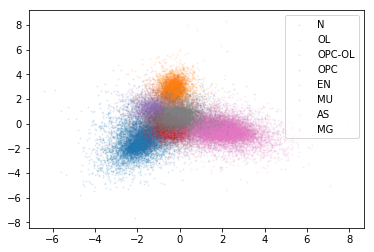

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
readout = CSC.readouts[0].copy()
pca = PCA(n_components=2)
readout_df = pd.DataFrame(readout,index=SCMatrix.columns)
x = StandardScaler().fit_transform(readout_df)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,index=SCMatrix.columns)
principalDf['cell_type'] = [i.split('_')[-1] for i in principalDf.index]
for cell_type in principalDf['cell_type'].unique():
    temp_df = principalDf[principalDf['cell_type']==cell_type]
    plt.scatter(temp_df[0],temp_df[1],s=1,alpha=0.1,label=cell_type)
plt.legend()
plt.show()

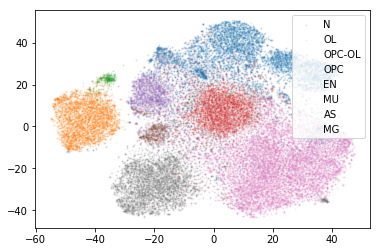

In [6]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
readout_df = pd.DataFrame(readout,index=SCMatrix.columns)
x = StandardScaler().fit_transform(readout_df)
principalComponents = TSNE(n_components=2).fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,index=SCMatrix.columns)
principalDf['cell_type'] = [i.split('_')[-1] for i in principalDf.index]
for cell_type in principalDf['cell_type'].unique():
    temp_df = principalDf[principalDf['cell_type']==cell_type]
    plt.scatter(temp_df[0],temp_df[1],s=1,alpha=0.1,label=cell_type)
plt.legend()
plt.show()

In [ ]:
plt.scatter(readout[:,0],readout[:,1],s=1,alpha=0.5)
plt.show()

In [ ]:
def generate_random(ngenes,nbits,npos=50):
    species = np.zeros((ngenes,nbits))
    for i in range(nbits):
        x =random.sample(list(range(ngenes)),50)
        species[x,i] = 1
    return species

In [ ]:
def generate_starting_survivors(ngenes,nbits,keepers=10):
    survivors = []
    for k in range(keepers):
        survivors.append(generate_random(ngenes,nbits,npos=50))
    return survivors

In [ ]:
def generate_mutations(species,mutation_rate=0.1,npos=50):
    mutated = species.copy()
    ideal = np.zeros(ngenes)
    ideal[0:npos] = 1
    ideal = list(ideal)
    for y in range(nbits):
        for x in random.sample(list(range(ngenes)),int(mutation_rate*ngenes)):
            mutated[x,y] = random.sample(ideal,1)[0]
    return mutated

In [ ]:
def generate_offspring(species,mate,ngenes=0):
    if ngenes==0:
        ngenes = species.shape[0]
    offspring_binary = species.copy()
    for y in range(nbits):
        for x in random.sample(list(range(ngenes)),int(ngenes/2)):
            offspring_binary[x,y] = mate[x,y]
    return offspring_binary

In [ ]:
def generate_progenerators(survivors,ngenes,offspring_number=2,ncpu=30):
    progenerators = survivors.copy()
    for species in survivors:
        for i in range(offspring_number):
            mate = survivors[random.randint(0,len(survivors)-1)].copy()
            progenerators.append(generate_offspring(species,mate))
    return progenerators

In [ ]:
def pfunc_generate_mutations(species,mutation_number=10,mutation_rate=0.1,npos=50):
    ppopulation = []
    for i in range(mutation_number):
        ppopulation.append(generate_mutations(species,mutation_rate=0.1,npos=50))
    return ppopulation

In [ ]:
def generate_population(progenerators,mutation_number=10,mutation_rate=0.1,npos=50,ncpu=30):
    population = progenerators.copy()
    if mutation_number>0:
        if ncpu==1:
            for species in progenerators:
                for i in range(mutation_number):
                    population.append(generate_mutations(species,mutation_rate=0.1,npos=50))
        else:
            sys.stdout.flush()
            with Pool(ncpu) as p:
                pfunc = partial(pfunc_generate_mutations,mutation_number=mutation_number,mutation_rate=mutation_rate,npos=npos)
                for ppopulation in p.imap(pfunc,progenerators,chunksize=1):
                    for species in ppopulation:
                        population.append(species)
            sys.stdout.flush()
    return population

In [ ]:
def generate_readout(species,SCMatrix_Sparse,ncells,nbits):
    readout = np.empty((ncells,nbits))
    out = []
    for i in range(nbits):
        multiplication_Sparse = SCMatrix_Sparse.multiply(species[:,i][...,None])
        readout[:,i] = multiplication_Sparse.sum(axis=0)
    return readout

In [ ]:
def calculate_metric(readout,cells,k=100,s=1000):
    metrics = []
    correlations = []
    for i in random.sample(list(range(len(cells))),s):
        individual = readout[i,:].copy()
        distance = np.sqrt(np.sum(np.subtract(readout.copy(),individual)**2,axis=1))
        distance_df = pd.DataFrame(distance,index=cells)
        knn = distance_df.sort_values(0)[:k+1].index
        sig = SCMatrix[knn[0]]
        avg = np.average(SCMatrix[knn[1:]],axis=1)
        metric = np.sum((sig-avg)**2)/nbits #MSE
        correlation = spearmanr(sig,avg)[0]
        metrics.append(metric)
        correlations.append(correlation)
        metric = np.average(metrics)
        correlation = np.average(correlation)
    return metric,correlation

In [ ]:
def wrapper(species,SCMatrix_Sparse,ncells,nbits,cells,k=100,s=1000):
    readout = generate_readout(species,SCMatrix_Sparse,ncells,nbits)
    metric,correlation = calculate_metric(readout,cells,k=100,s=1000)
    return species,readout,metric,correlation

In [ ]:
def selection(population,readouts,metrics,correlations,keepers=10):
    df = pd.DataFrame(index=range(len(population)))
    df['population'] = population
    df['metrics'] = metrics
    df['readouts'] = readouts
    df['correlations'] = correlations
    df = df.sort_values('metrics',ascending=True)
    survivors = df.iloc[:keepers]
    metrics = list(survivors['metrics'])
    readouts = list(survivors['readouts'])
    correlations = list(survivors['correlations'])
    survivors = list(survivors['population'])
    elite_survivor = survivors[0]
    return survivors,metrics,readouts,correlations,elite_survivor

In [ ]:
nbits = 18
genes = list(SCMatrix.index)
cells = list(SCMatrix.columns)
ncells = len(cells)
ngenes = len(genes)

from scipy.sparse import csr_matrix
SCMatrix_Sparse = csr_matrix(SCMatrix)

k=100
s=1000
keepers = 10
offspring_number=0
mutation_number=2
mutation_rate=0.1
npos=50
ncpu=30

start = time.time()

survivors = generate_starting_survivors(ngenes,nbits,keepers=keepers)
progenerators = generate_progenerators(survivors,ngenes,offspring_number=offspring_number)
population = generate_population(progenerators,mutation_number=mutation_number,
                                 mutation_rate=mutation_rate,npos=npos,ncpu=ncpu)
new_population = []
readouts = []
metrics = []
correlations = []
if ncpu==1:
    for species in tqdm.tqdm(population):
        readout = generate_readout(species,SCMatrix_Sparse,ncells,nbits)
        metric,correlation = calculate_metric(readout,cells,k=k,s=s)
        new_population.append(species)
        readouts.append(readout)
        metrics.append(metric)
        correlations.append(correlation)
else:
    sys.stdout.flush()
    with Pool(ncpu) as p:
        pfunc = partial(wrapper,SCMatrix_Sparse=SCMatrix_Sparse,ncells=ncells,nbits=nbits,cells=cells,k=k,s=s)
        for species,readout,metric,correlation in tqdm.tqdm(p.imap(pfunc,population,chunksize=1),total=len(population)):
            new_population.append(species)
            readouts.append(readout)
            metrics.append(metric)
            correlations.append(correlation)
    sys.stdout.flush()
survivors,metrics,readouts,correlations,elite_survivor = selection(new_population,readouts,metrics,correlations,keepers=keepers)
print(time.time()-start)
